<a href="https://colab.research.google.com/github/mrzhuzhe/pepper/blob/master/BMS_vision_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download dataset

In [ ]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.7/dist-packages (1.5.12)


In [ ]:
# collab dependence
!pip install tensorflow-addons
!pip install gcsfs
!pip install fsspec

     |████████████████████████████████| 686kB 3.2MB/s 
     |████████████████████████████████| 1.3MB 3.4MB/s 
     |████████████████████████████████| 122kB 13.3MB/s 
     |████████████████████████████████| 296kB 12.4MB/s 
     |████████████████████████████████| 143kB 13.5MB/s 


In [ ]:
%env KAGGLE_USERNAME=drzhuzhe
%env KAGGLE_KEY=14db5a9e48003385a3a300c1f794dcdc

env: KAGGLE_USERNAME=drzhuzhe
env: KAGGLE_KEY=14db5a9e48003385a3a300c1f794dcdc


In [ ]:
INPUT_DIR = './input'

In [ ]:
import pandas as pd
import numpy as np

import tensorflow as tf
import tensorflow_addons as tfa
from datetime import datetime
import random
import shutil
import math
import time
import sys
import io
import os
import gc

import matplotlib.pyplot as plt

import cv2

In [ ]:
print(f"\n... ACCELERATOR SETUP STARTING ...\n")

# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    TPU=tf.distribute.cluster_resolver.TPUClusterResolver()  
except ValueError:
    TPU=None

if TPU:
    print(f"\n... RUNNING ON TPU - {TPU.master()}...")
    tf.config.experimental_connect_to_cluster(TPU)
    tf.tpu.experimental.initialize_tpu_system(TPU)
    strategy=tf.distribute.experimental.TPUStrategy(TPU)
else:
    print(f"\n... RUNNING ON CPU/GPU ...")
    # Yield the default distribution strategy in Tensorflow
    #   --> Works on CPU and single GPU.
    strategy=tf.distribute.get_strategy() 

# What Is a Replica?
#    --> A single Cloud TPU device consists of FOUR chips, each of which has TWO TPU cores. 
#    --> Therefore, for efficient utilization of Cloud TPU, a program should make use of each of the EIGHT (4x2) cores. 
#    --> Each replica is essentially a copy of the training graph that is run on each core and 
#        trains a mini-batch containing 1/8th of the overall batch size
N_REPLICAS=strategy.num_replicas_in_sync
    
print(f"... # OF REPLICAS: {N_REPLICAS} ...\n")

print(f"\n... ACCELERATOR SETUP COMPLTED ...\n")


... ACCELERATOR SETUP STARTING ...


... RUNNING ON TPU - grpc://10.76.52.122:8470...
INFO:tensorflow:Initializing the TPU system: grpc://10.76.52.122:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.76.52.122:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


... # OF REPLICAS: 8 ...


... ACCELERATOR SETUP COMPLTED ...



In [ ]:
print("\n... DATA ACCESS SETUP STARTED ...\n")

#if TPU:
    # Google Cloud Dataset path to training and validation images
# gcs Input tfrecord 
DATA_DIR='gs://kds-d4383f77b1572fed62b6b582c9593c9feb1166fa14c8a86238834f7c'

#DATA_DIR= './imnput/bms-train-tfrecords-half-length'

print(f"\n... DATA DIRECTORY PATH IS:\n\t--> {DATA_DIR}")

print(f"\n... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:")
for file in tf.io.gfile.glob(os.path.join(DATA_DIR, "*")): print(f"\t--> {file}")

print("\n\n... DATA ACCESS SETUP COMPLETED ...\n")


... DATA ACCESS SETUP STARTED ...


... DATA DIRECTORY PATH IS:
	--> gs://kds-d4383f77b1572fed62b6b582c9593c9feb1166fa14c8a86238834f7c

... IMMEDIATE CONTENTS OF DATA DIRECTORY IS:
	--> gs://kds-d4383f77b1572fed62b6b582c9593c9feb1166fa14c8a86238834f7c/train_records
	--> gs://kds-d4383f77b1572fed62b6b582c9593c9feb1166fa14c8a86238834f7c/val_records


... DATA ACCESS SETUP COMPLETED ...



In [ ]:
print(f"\n... MIXED PRECISION SETUP STARTING ...\n")
print("\n... SET TF TO OPERATE IN MIXED PRECISION – `bfloat16` – IF ON TPU ...")

# Set Mixed Precision Global Policy
#     ---> To use mixed precision in Keras, you need to create a `tf.keras.mixed_precision.Policy`
#          typically referred to as a dtype policy. 
#     ---> Dtype policies specify the dtypes layers will run in
tf.keras.mixed_precision.set_global_policy('mixed_bfloat16' if TPU else 'float32')

# target data type, bfloat16 when using TPU to improve throughput
TARGET_DTYPE=tf.bfloat16 if TPU else tf.float32
print(f"\t--> THE TARGET DTYPE HAS BEEN SET TO {TARGET_DTYPE} ...")

# The policy specifies two important aspects of a layer: 
#     1. The dtype the layer's computations are done in
#     2. The dtype of a layer's variables. 
print(f"\n... TWO IMPORTANT ASPECTS OF THE GLOBAL MIXED PRECISION POLICY:")
print(f'\t--> COMPUTE DTYPE  : {tf.keras.mixed_precision.global_policy().compute_dtype}')
print(f'\t--> VARIABLE DTYPE : {tf.keras.mixed_precision.global_policy().variable_dtype}')

print(f"\n\n... MIXED PRECISION SETUP COMPLTED ...\n")


... MIXED PRECISION SETUP STARTING ...


... SET TF TO OPERATE IN MIXED PRECISION – `bfloat16` – IF ON TPU ...
	--> THE TARGET DTYPE HAS BEEN SET TO <dtype: 'bfloat16'> ...

... TWO IMPORTANT ASPECTS OF THE GLOBAL MIXED PRECISION POLICY:
	--> COMPUTE DTYPE  : bfloat16
	--> VARIABLE DTYPE : float32


... MIXED PRECISION SETUP COMPLTED ...



In [ ]:
print(f"\n... XLA OPTIMIZATIONS STARTING ...\n")

print(f"\n... CONFIGURE JIT (JUST IN TIME) COMPILATION ...\n")
# enable XLA optmizations (10% speedup when using @tf.function calls)
tf.config.optimizer.set_jit(True)

print(f"\n... XLA OPTIMIZATIONS COMPLETED ...\n")


... XLA OPTIMIZATIONS STARTING ...


... CONFIGURE JIT (JUST IN TIME) COMPILATION ...


... XLA OPTIMIZATIONS COMPLETED ...



In [ ]:
#KaggleDatasets().get_gcs_path('bms-csvs-w-extra-metadata')
metadata_GCS = 'gs://kds-8c6c4b36199253c24acd9b057d06a32b939b7cddf06161d9dc1f3f4a'

In [ ]:
print("\n... BASIC DATA SETUP STARTING ...\n")

# All the possible tokens in our InChI 'language'
TOKEN_LIST=["<PAD>", "InChI=1S/", "<END>", "/c", "/h", "/m", "/t", "/b", "/s", "/i"] +\
             ['Si', 'Br', 'Cl', 'F', 'I', 'N', 'O', 'P', 'S', 'C', 'H', 'B', ] +\
             [str(i) for i in range(167,-1,-1)] +\
             ["\+", "\(", "\)", "\-", ",", "D", "T"]
print(f"\n... TOKEN LIST:")
for i, tok in enumerate(TOKEN_LIST): print(f"\t--> INTEGER-IDX={i:<3}  –––  STRING={tok}")

# The start/end/pad tokens will be removed from the string when computing the Levenshtein distance
# We want them as tf.constant's so they will operate properly within the @tf.function context
START_TOKEN=tf.constant(TOKEN_LIST.index("InChI=1S/"), dtype=tf.uint8)
END_TOKEN=tf.constant(TOKEN_LIST.index("<END>"), dtype=tf.uint8)
PAD_TOKEN=tf.constant(TOKEN_LIST.index("<PAD>"), dtype=tf.uint8)

# Prefixes and Their Respective Ordering/Format
#      -- ORDERING --> {c}{h/None}{b/None}{t/None}{m/None}{s/None}{i/None}{h/None}{t/None}{m/None}
PREFIX_ORDERING="chbtmsihtm"
print(f"\n... PREFIX ORDERING IS {PREFIX_ORDERING} ...")

# Paths to Respective Image Directories
TRAIN_DIR=os.path.join(DATA_DIR, "train_records")
VAL_DIR=os.path.join(DATA_DIR, "val_records")
#TEST_DIR=os.path.join(TEST_DATA_DIR, "test_records")

# Get the Full Paths to The Individual TFRecord Files
TRAIN_TFREC_PATHS=sorted(
    tf.io.gfile.glob(os.path.join(TRAIN_DIR, "*.tfrec")), 
    key=lambda x: int(x.rsplit("_", 2)[1]))
VAL_TFREC_PATHS=sorted(
    tf.io.gfile.glob(os.path.join(VAL_DIR, "*.tfrec")), 
    key=lambda x: int(x.rsplit("_", 2)[1]))

"""
TEST_TFREC_PATHS=sorted(
    tf.io.gfile.glob(os.path.join(TEST_DIR, "*.tfrec")), 
    key=lambda x: int(x.rsplit("_", 2)[1]))
"""


print(f"\n... TFRECORD INFORMATION:")
for SPLIT, TFREC_PATHS in zip(["TRAIN", "VAL"
                              # , "TEST"
                              ], [TRAIN_TFREC_PATHS, VAL_TFREC_PATHS
                              #    , TEST_TFREC_PATHS
                                 ]):
    print(f"\t--> {len(TFREC_PATHS):<3} {SPLIT:<5} TFRECORDS")

# Paths to relevant CSV files containing training and submission information
#TRAIN_CSV_PATH=os.path.join(metadata_GCS, "bms-csvs-w-extra-metadata", "train_labels_w_extra.csv")
TRAIN_CSV_PATH=os.path.join(metadata_GCS, "train_labels_w_extra.csv")
#SS_CSV_PATH   =os.path.join(metadata_GCS, "bms-csvs-w-extra-metadata", "sample_submission_w_extra.csv")
SS_CSV_PATH   =os.path.join(metadata_GCS, "sample_submission_w_extra.csv")
print(f"\n... PATHS TO CSVS:")
print(f"\t--> TRAIN CSV: {TRAIN_CSV_PATH}")
print(f"\t--> SS CSV   : {SS_CSV_PATH}")

# When debug is true we use a smaller batch size and smaller model
DEBUG=False

print("\n\n... BASIC DATA SETUP COMPLETED ...\n")


... BASIC DATA SETUP STARTING ...


... TOKEN LIST:
	--> INTEGER-IDX=0    –––  STRING=<PAD>
	--> INTEGER-IDX=1    –––  STRING=InChI=1S/
	--> INTEGER-IDX=2    –––  STRING=<END>
	--> INTEGER-IDX=3    –––  STRING=/c
	--> INTEGER-IDX=4    –––  STRING=/h
	--> INTEGER-IDX=5    –––  STRING=/m
	--> INTEGER-IDX=6    –––  STRING=/t
	--> INTEGER-IDX=7    –––  STRING=/b
	--> INTEGER-IDX=8    –––  STRING=/s
	--> INTEGER-IDX=9    –––  STRING=/i
	--> INTEGER-IDX=10   –––  STRING=Si
	--> INTEGER-IDX=11   –––  STRING=Br
	--> INTEGER-IDX=12   –––  STRING=Cl
	--> INTEGER-IDX=13   –––  STRING=F
	--> INTEGER-IDX=14   –––  STRING=I
	--> INTEGER-IDX=15   –––  STRING=N
	--> INTEGER-IDX=16   –––  STRING=O
	--> INTEGER-IDX=17   –––  STRING=P
	--> INTEGER-IDX=18   –––  STRING=S
	--> INTEGER-IDX=19   –––  STRING=C
	--> INTEGER-IDX=20   –––  STRING=H
	--> INTEGER-IDX=21   –––  STRING=B
	--> INTEGER-IDX=22   –––  STRING=167
	--> INTEGER-IDX=23   –––  STRING=166
	--> INTEGER-IDX=24   –––  STRING=165
	--> INTEGER-ID

In [ ]:
 print("\n... INITIAL DATAFRAME INSTANTIATION STARTING ...\n")

# Load the train and submission dataframes
train_df=pd.read_csv(TRAIN_CSV_PATH)
ss_df   =pd.read_csv(SS_CSV_PATH)

# --- Distribution Information ---
N_EX   =len(train_df)
N_TEST =len(ss_df)
N_VAL  =80_000 # Fixed from dataset creation information
N_TRAIN=N_EX-N_VAL

# --- Batching Information ---
BATCH_SIZE_DEBUG=2

#REPLICA_BATCH_SIZE=64 # Could probably be 128
REPLICA_BATCH_SIZE=24

if DEBUG:
    REPLICA_BATCH_SIZE=BATCH_SIZE_DEBUG
OVERALL_BATCH_SIZE=REPLICA_BATCH_SIZE*N_REPLICAS


# --- Input Image Information ---
IMG_SHAPE=(192,384,3)

# --- Autocalculate Training/Validation/Testing Information ---
TRAIN_STEPS=N_TRAIN  // OVERALL_BATCH_SIZE
VAL_STEPS  =N_VAL    // OVERALL_BATCH_SIZE
TEST_STEPS =int(np.ceil(N_TEST/OVERALL_BATCH_SIZE))

# This is for padding our test dataset so we only have whole batches
REQUIRED_DATASET_PAD=OVERALL_BATCH_SIZE-N_TEST%OVERALL_BATCH_SIZE

# --- Modelling Information ---
ATTN_EMB_DIM =192
N_RNN_UNITS  =512

print(f"\n... # OF TRAIN+VAL EXAMPLES  : {N_EX:<7} ...")
print(f"... # OF TRAIN EXAMPLES      : {N_TRAIN:<7} ...")
print(f"... # OF VALIDATION EXAMPLES : {N_VAL:<7} ...")
print(f"... # OF TEST EXAMPLES       : {N_TEST:<7} ...\n")

print(f"\n... REPLICA BATCH SIZE    : {REPLICA_BATCH_SIZE} ...")
print(f"... OVERALL BATCH SIZE    : {OVERALL_BATCH_SIZE} ...\n")

print(f"\n... IMAGE SHAPE           : {IMG_SHAPE} ...\n")

print(f"\n... TRAIN STEPS PER EPOCH : {TRAIN_STEPS:<5} ...")
print(f"... VAL STEPS PER EPOCH   : {VAL_STEPS:<5} ...")
print(f"... TEST STEPS PER EPOCH  : {TEST_STEPS:<5} ...\n")

print(f"\n... ATTENTION EMBEDDING DIMENSION : {ATTN_EMB_DIM:<5} ...")
print(f"... NUMBER OF UNITS IN LSTM       : {N_RNN_UNITS:<5} ...\n")

print("\n... TRAIN DATAFRAME ...\n")
display(train_df.head(3))

print("\n... SUBMISSION DATAFRAME ...\n")
display(ss_df.head(3))

print("\n... INITIAL DATAFRAME INSTANTIATION COMPLETED...\n")


... INITIAL DATAFRAME INSTANTIATION STARTING ...




... # OF TRAIN+VAL EXAMPLES  : 2344186 ...
... # OF TRAIN EXAMPLES      : 2264186 ...
... # OF VALIDATION EXAMPLES : 80000   ...
... # OF TEST EXAMPLES       : 1616107 ...


... REPLICA BATCH SIZE    : 24 ...
... OVERALL BATCH SIZE    : 192 ...


... IMAGE SHAPE           : (192, 384, 3) ...


... TRAIN STEPS PER EPOCH : 11792 ...
... VAL STEPS PER EPOCH   : 416   ...
... TEST STEPS PER EPOCH  : 8418  ...


... ATTENTION EMBEDDING DIMENSION : 192   ...
... NUMBER OF UNITS IN LSTM       : 512   ...


... TRAIN DATAFRAME ...



,image_id,InChI,img_path,inchi_token_len,roi_bbox,crop_width,crop_height,aspect_ratio
0,086e77fe6edf,InChI=1S/C21H25N3O2S/c1-5-6-16-13-18(27-14(16)...,/kaggle/input/bms-molecular-translation/train/...,97,"(24, 23, 237, 184)",213,161,1.322981
1,086e891d2e10,"InChI=1S/C25H27N5O3/c1-25(2,3)33-24(31)29-14-1...",/kaggle/input/bms-molecular-translation/train/...,106,"(23, 23, 333, 200)",310,177,1.751412
2,086e8f6bc917,InChI=1S/C16H15N3O2/c1-11-7-13-16(17-9-11)19(1...,/kaggle/input/bms-molecular-translation/train/...,82,"(39, 38, 329, 270)",290,232,1.250000



... SUBMISSION DATAFRAME ...



,image_id,InChI,img_path,roi_bbox,crop_width,crop_height,aspect_ratio
0,00000d2a601c,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 1, 318, 205)",280,204,1.372549
1,00001f7fc849,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 38, 226, 401)",188,363,0.517906
2,000037687605,InChI=1S/H2O/h1H2,/kaggle/input/bms-molecular-translation/test/0...,"(38, 38, 297, 349)",259,311,0.832797



... INITIAL DATAFRAME INSTANTIATION COMPLETED...



# Prepare Dataset

In [ ]:
print("\n... SPECIAL VARIABLE SETUP STARTING ...\n")


# Whether to start training using previously checkpointed model
LOAD_MODEL       =False
ENCODER_CKPT_PATH=""
DECODER_CKPT_PATH=""

if LOAD_MODEL:
    print(f"\n... ENCODER MODEL TRAINING WILL RESUME FROM PREVIOUS CHECKPOINT:\n\t-->{ENCODER_CKPT_PATH}\n")
    print(f"... DECODER MODEL TRAINING WILL RESUME FROM PREVIOUS CHECKPOINT:\n\t-->{DECODER_CKPT_PATH}\n")
else:
    print(f"\n... MODEL TRAINING WILL START FROM SCRATCH ...\n")

    
print("\n... SPECIAL VARIABLE SETUP COMPLETED ...\n")


... SPECIAL VARIABLE SETUP STARTING ...


... MODEL TRAINING WILL START FROM SCRATCH ...


... SPECIAL VARIABLE SETUP COMPLETED ...



In [ ]:
def flatten_l_o_l(nested_list):
    """ Flatten a list of lists """
    return [item for sublist in nested_list for item in sublist]


def tf_load_image(path, img_size=(192,384,3), invert=False):
    """ Load an image with the correct size and shape 
    
    Args:
        path (tf.string): Path to the image to be loaded
        img_size (tuple, optional): Size to reshape image to (required for TPU)
        tile_to_3_channel (bool, optional): Whether to tile the single channel
            image to 3 channels which will be required for most off-the-shelf models
        invert (bool, optional): Whether or not to invert the background/foreground
    
    Returns:
        3 channel tf.Constant image ready for training/inference
    
    """
    img=decode_img(tf.io.read_file(path), img_size, n_channels=3, invert=invert)        
    return img
    
    
def decode_image(image_data, resize_to=(192,384,3)):
    """ Function to decode the tf.string containing image information 
    
    
    Args:
        image_data (tf.string): String containing encoded image data from tf.Example
        resize_to (tuple, optional): Size that we will reshape the tensor to (required for TPU)
    
    Returns:
        Tensor containing the resized single-channel image in the appropriate dtype
    """
    image=tf.image.decode_png(image_data, channels=3)
    image=tf.reshape(image, resize_to)
    return tf.cast(image, TARGET_DTYPE)
    
    
# sparse tensors are required to compute the Levenshtein distance
def dense_to_sparse(dense):
    """ Convert a dense tensor to a sparse tensor 
    
    Args:
        dense (Tensor): TBD
        
    Returns:
        A sparse tensor    
    """
    indices=tf.where(tf.ones_like(dense))
    values=tf.reshape(dense, (MAX_LEN*OVERALL_BATCH_SIZE,))
    sparse=tf.SparseTensor(indices, values, dense.shape)
    return sparse

def get_levenshtein_distance(preds, lbls):
    """ Computes the Levenshtein distance between the predictions and labels 
    
    Args:
        preds (tensor): Batch of predictions
        lbls (tensor): Batch of labels
        
    Returns:
        The mean Levenshtein distance calculated across the batch
    """
    preds=tf.where(tf.not_equal(lbls, END_TOKEN) & tf.not_equal(lbls, PAD_TOKEN), preds, 0)
    lbls=tf.where(tf.not_equal(lbls, END_TOKEN), lbls, 0)

    preds_sparse=dense_to_sparse(preds)
    lbls_sparse=dense_to_sparse(lbls)

    batch_distance=tf.edit_distance(preds_sparse, lbls_sparse, normalize=False)
    mean_distance=tf.math.reduce_mean(batch_distance)
    
    return mean_distance

In [ ]:
print("\n\n... STARTING PREPARING VARIABLES FOR DATASET ...\n")

tok_2_int={c.strip("\\"):i for i,c in enumerate(TOKEN_LIST)}
int_2_tok={v:k for k,v in tok_2_int.items()}

# Max Length Was Determined Previously Using... 
#     >>> MAX_LEN=train_df.InChI.progress_apply(lambda x: len(re.findall("|".join(TOKEN_LIST), x))).max()+1
MAX_LEN=((train_df.inchi_token_len.max()+1)//2) # //2 yields 138... which is half of max length (speeds up training)
VOCAB_LEN=len(int_2_tok)

print(f"\t--> TOKEN TO INTEGER MAP     : {tok_2_int}")
print(f"\t--> INTEGER TO TOKEN MAP     : {int_2_tok}")
print(f"\t--> MAX # OF TOKENS IN INCHI : {MAX_LEN}")
print(f"\t--> LENGTH OF VOCAB          : {VOCAB_LEN}")

print(f"\n\n\t--> CONVERTED INCHI STRINGS  :")
for i, row in train_df.iloc[:N_VAL].sample(3).iterrows():
    print(f"\n\t\t--> EXAMPLE #{i} FROM THE VALIDATION DATASET")
    print("\t\t\t--> RAW INCHI : ", row["InChI"])

print("\n\n... PREPARING VARIABLES FOR DATASET COMPLETED ...\n")



... STARTING PREPARING VARIABLES FOR DATASET ...

	--> TOKEN TO INTEGER MAP     : {'<PAD>': 0, 'InChI=1S/': 1, '<END>': 2, '/c': 3, '/h': 4, '/m': 5, '/t': 6, '/b': 7, '/s': 8, '/i': 9, 'Si': 10, 'Br': 11, 'Cl': 12, 'F': 13, 'I': 14, 'N': 15, 'O': 16, 'P': 17, 'S': 18, 'C': 19, 'H': 20, 'B': 21, '167': 22, '166': 23, '165': 24, '164': 25, '163': 26, '162': 27, '161': 28, '160': 29, '159': 30, '158': 31, '157': 32, '156': 33, '155': 34, '154': 35, '153': 36, '152': 37, '151': 38, '150': 39, '149': 40, '148': 41, '147': 42, '146': 43, '145': 44, '144': 45, '143': 46, '142': 47, '141': 48, '140': 49, '139': 50, '138': 51, '137': 52, '136': 53, '135': 54, '134': 55, '133': 56, '132': 57, '131': 58, '130': 59, '129': 60, '128': 61, '127': 62, '126': 63, '125': 64, '124': 65, '123': 66, '122': 67, '121': 68, '120': 69, '119': 70, '118': 71, '117': 72, '116': 73, '115': 74, '114': 75, '113': 76, '112': 77, '111': 78, '110': 79, '109': 80, '108': 81, '107': 82, '106': 83, '105': 84, '104': 8

In [ ]:
print("\n... CREATE TFRECORD RAW DATASETS STARTING ...\n")

# Create tf.data.Dataset from filepaths for conversion later
raw_train_ds=tf.data.TFRecordDataset(TRAIN_TFREC_PATHS, num_parallel_reads=None)
raw_val_ds=tf.data.TFRecordDataset(VAL_TFREC_PATHS, num_parallel_reads=None)
#raw_test_ds=tf.data.TFRecordDataset(TEST_TFREC_PATHS, num_parallel_reads=None)

# raw_test_ds=tf.data.TFRecordDataset(TEST_TFREC_PATHS, num_parallel_reads=None)

print(f"\n... THE RAW TF.DATA.TFRECORDDATASET OBJECT:\n\t--> {raw_train_ds}\n")

print("\n... CREATE TFRECORD RAW DATASETS COMPLETED ...\n")


... CREATE TFRECORD RAW DATASETS STARTING ...


... THE RAW TF.DATA.TFRECORDDATASET OBJECT:
	--> <TFRecordDatasetV2 shapes: (), types: tf.string>


... CREATE TFRECORD RAW DATASETS COMPLETED ...



In [ ]:
print("\n... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS STARTED ...\n")

print("\n... EXAMPLE OF TRUNCATED RAW TFRECORD/TFEXAMPLE FROM TRAINING DATASET TO SHOW HOW TO FIND FEATURE DESCRIPTIONS:\n")
# See an example
for raw in raw_train_ds.take(1):
    example=tf.train.Example()
    example.ParseFromString(raw.numpy())
    for i, (k,v) in enumerate(example.features.feature.items()):
        print(f"\tFEATURE #{i+1}")
        print(f"\t\t--> KEY={k}")
        if k!="image":
            try:
                print(f"\t\t\t--> TRUNCATED-VALUE={v.int64_list.value[:15]} ...\n")
            except:
                print(f"\t\t\t--> TRUNCATED-VALUE={v.bytes_list.value[0][:25]} ...\n")
        else:
            print(f"\t\t\t--> TRUNCATED-VALUE={str(v.bytes_list.value[0][:25])} ...\n")         

print("\n... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS COMPLETED ...\n")


... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS STARTED ...


... EXAMPLE OF TRUNCATED RAW TFRECORD/TFEXAMPLE FROM TRAINING DATASET TO SHOW HOW TO FIND FEATURE DESCRIPTIONS:

	FEATURE #1
		--> KEY=inchi
			--> TRUNCATED-VALUE=[1, 19, 181, 20, 179, 12, 15, 186, 16, 187, 18, 3, 188, 193, 187] ...

	FEATURE #2
		--> KEY=image
			--> TRUNCATED-VALUE=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x01\x80\x00\x00\x00\xc0\x08' ...


... RAW TFRECORD INVESTIGATION TO DETERMINE FEATURE DESCRIPTIONS COMPLETED ...



In [ ]:
def decode(serialized_example, is_test=False, tokenized_inchi=True):
    """ Parses a set of features and label from the given `serialized_example`.
        
        It is used as a map function for `dataset.map`

    Args:
        serialized_example (tf.Example): A serialized example containing the
            following features:
                – 'image'
                – 'image_id'
                – 'inchi'
        is_test (bool, optional): Whether to allow for the InChI feature
        drop_id (bool, optional): Whether or not to drop the ID feature
        
    Returns:
        A decoded tf.data.Dataset object representing the tfrecord dataset
    """
    feature_dict={
        'image': tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value=''),
    }
    
    if not is_test:
        if tokenized_inchi:
            feature_dict["inchi"]=tf.io.FixedLenFeature(shape=[MAX_LEN], dtype=tf.int64, default_value=[0]*MAX_LEN)
        else:
            feature_dict["inchi"]=tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
    else:
        feature_dict["image_id"]=tf.io.FixedLenFeature(shape=[], dtype=tf.string, default_value='')
    
    # Define a parser
    features=tf.io.parse_single_example(serialized_example, features=feature_dict)
    
    # Decode the tf.string
    image=decode_image(features['image'], resize_to=IMG_SHAPE)
    
    # Figure out the correct information to return
    if is_test:
        image_id=features["image_id"] 
        return image, image_id
    else:
        if tokenized_inchi:
            target=tf.cast(features["inchi"], tf.uint8)
        else:
            target=features["inchi"]
        return image, target


... DECODING RAW TFRECORD DATASETS STARTING ...


... THE DECODED TF.DATA.TFRECORDDATASET OBJECT:
	--> ((image), (image_id - optional), (inchi))
	--> <MapDataset shapes: ((192, 384, 3), (138,)), types: (tf.bfloat16, tf.uint8)>


... 2 EXAMPLES OF IMAGES AND LABELS AFTER DECODING ...

IMAGE SHAPE : (192, 384, 3)
IMAGE INCHI : ['InChI=1S/', 'C', '8', 'H', '10', 'Cl', 'N', '3', 'O', '2', 'S', '/c', '1', '-', '2', '-', '12', '-', '5', '-', '11', '-', '15', '(', '13', ',', '14', ')', '7', '-', '3', '-', '6', '(', '9', ')', '4', '-', '10', '-', '8', '(', '7', ')', '12', '/h', '3', '-', '4', ',', '11', 'H', ',', '2', ',', '5', 'H', '2', ',', '1', 'H', '3', '<END>', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>',

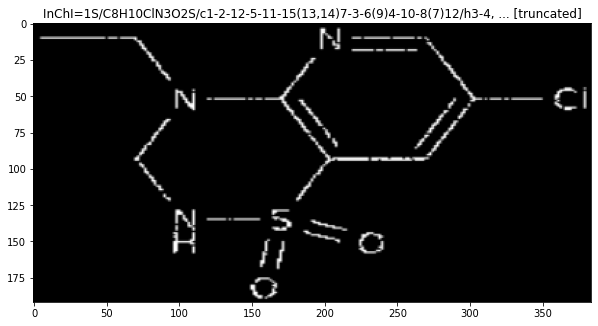


IMAGE SHAPE : (192, 384, 3)
IMAGE INCHI : ['InChI=1S/', 'C', '23', 'H', '33', 'N', '3', 'O', '2', 'S', '/c', '1', '-', '14', '-', '10', '-', '15', '(', '2', ')', '25', '-', '23', '(', '28', ')', '19', '(', '14', ')', '12', '-', '24', '-', '22', '(', '27', ')', '20', '-', '13', '-', '29', '-', '21', '(', '16', '(', '20', ')', '3', ')', '11', '-', '17', '-', '6', '-', '8', '-', '18', '(', '9', '-', '7', '-', '17', ')', '26', '(', '4', ')', '5', '/h', '10', ',', '13', ',', '17', '-', '18', 'H', ',', '6', '-', '9', ',', '11', '-', '12', 'H', '2', ',', '1', '-', '5', 'H', '3', ',', '(', 'H', ',', '24', ',', '27', ')', '(', 'H', ',', '25', ',', '28', ')', '<END>', '<END>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']



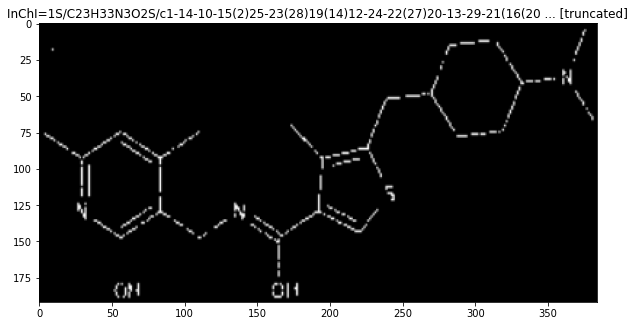


... DECODING RAW TFRECORD DATASETS COMPLETED ...



In [ ]:
print("\n... DECODING RAW TFRECORD DATASETS STARTING ...\n")

# Decode the tfrecords completely –– decode is our `_parse_function` (from recipe above)
train_ds=raw_train_ds.map(lambda x: decode(x, is_test=False))
val_ds=raw_val_ds.map(lambda x: decode(x, is_test=False))
#test_ds=raw_test_ds.map(lambda x: decode(x, is_test=True))

print(f"\n... THE DECODED TF.DATA.TFRECORDDATASET OBJECT:" \
      f"\n\t--> ((image), (image_id - optional), (inchi))" \
      f"\n\t--> {train_ds}\n")

print("\n... 2 EXAMPLES OF IMAGES AND LABELS AFTER DECODING ...")
for i, (img, inchi) in enumerate(train_ds.take(2)):
    print(f"\nIMAGE SHAPE : {img.shape}")
    print(f"IMAGE INCHI : {[int_2_tok[x] for x in inchi.numpy()]}\n")
    plt.figure(figsize=(10,10))
    plt.imshow(img.numpy().astype(np.int64), cmap="gray")
    plt.title(f"{''.join([int_2_tok[x] for x in inchi.numpy() if x!=0][:50])} ... [truncated]")
    plt.show()

print("\n... DECODING RAW TFRECORD DATASETS COMPLETED ...\n")

In [ ]:
def load_dataset(filenames, is_test=False, ordered=False, tokenized_inchi=True):
    """Read from TFRecords.
    
    For optimal performance, reading from multiple files at once and disregarding data order (if `ordered=False`).
        - If pulling InChI from TFRecords than order does not matter since we will 
          be shuffling the data anyway (for training dataset).
          
    Args:
        filenames (list of strings): List of paths to that point to the respective TFRecord files
        is_test (bool, optional): Whether or not to include the image ID or label in the returned dataset
        ordered (bool, optional): Whether to ensured ordered results or maximize parallelization
        tokenized_inchi (bool, optional): Whether our dataset includes the tokenized inchi or we will be 
            creating it from the caption numpy array
        
    Returns:
        Decoded tf.data.Dataset object
    """

    options=tf.data.Options()
    if not ordered:
        # disable order, increase speed
        options.experimental_deterministic=False
        N_PARALLEL=tf.data.AUTOTUNE
    else:
        N_PARALLEL=None
        
    # If not-ordered, this will read in by automatically interleaving multiple tfrecord files.
    dataset=tf.data.TFRecordDataset(filenames, num_parallel_reads=N_PARALLEL)
    
    # If not-ordered, this will ensure that we use data as soon as it 
    # streams in, rather than in its original order.
    dataset=dataset.with_options(options) 
    
    # parse and return a dataset w/ the appropriate configuration
    dataset=dataset.map(
        lambda x: decode(x, is_test, tokenized_inchi),
        num_parallel_calls=N_PARALLEL,
    )
    
    return dataset

def get_dataset(filenames, batch_size, 
                is_test=False, 
                shuffle_buffer_size=1, 
                repeat_dataset=True, 
                preserve_file_order=False, 
                drop_remainder=True,
                tokenized_inchi=True,
                external_inchi_dataset=None,
                test_padding=0):
    """ Get a tf.data.Dataset w/ the appropriate configuration
    
    Args:
        TBD
        test_padding (int, optional): Amount required to pad dataset to have only full batches
        
    Returns:
        TBD
        
    """
    # Load the dataset
    dataset=load_dataset(filenames, is_test, preserve_file_order, tokenized_inchi)
    
    if test_padding!=0:
        pad_dataset=tf.data.Dataset.from_tensor_slices((
            tf.zeros((test_padding, *IMG_SHAPE), dtype=TARGET_DTYPE),       # Fake Images
            tf.constant(["000000000000",]*test_padding, dtype=tf.string))   # Fake IDs
        )
        dataset=dataset.concatenate(pad_dataset)
    
    # If we are training than we will want to repeat the dataset. 
    # We will determine the number of steps (or updates) later for 1 training epoch.
    if repeat_dataset:
        dataset=dataset.repeat()
    
    # If we need to add on manually the inchi
    if external_inchi_dataset is not None:
        # Zip the datasets and tile the 1 channel image to 3 channels & drop the old inchi value
        dataset=tf.data.Dataset.zip((dataset, external_inchi_dataset))
        dataset=dataset.map(lambda x,y: (tf.tile(tf.expand_dims(x[0], -1), tf.constant([1,1,3], tf.int32)), y))
                              
    # Shuffling
    if shuffle_buffer_size!=1:
        dataset=dataset.shuffle(shuffle_buffer_size)
    
    # Batching
    dataset=dataset.batch(batch_size, drop_remainder=drop_remainder)
    
    # prefetch next batch while training (autotune prefetch buffer size)
    dataset=dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset


... TRAINING CONFIGURATION:
	--> filenames              : ['records_01_57.tfrec', 'records_02_57.tfrec', '...']
	--> batch_size             : 192
	--> is_test                : False
	--> shuffle_buffer_size    : 1152
	--> repeat_dataset         : True
	--> preserve_file_order    : False
	--> drop_remainder         : True
	--> tokenized_inchi        : True
	--> external_inchi_dataset : None
	--> test_padding           : 0

... VALIDATION CONFIGURATION:
	--> filenames              : ['records_01_02.tfrec', 'records_02_02.tfrec', '...']
	--> batch_size             : 192
	--> is_test                : False
	--> shuffle_buffer_size    : 1
	--> repeat_dataset         : True
	--> preserve_file_order    : False
	--> drop_remainder         : True
	--> tokenized_inchi        : True
	--> external_inchi_dataset : None
	--> test_padding           : 0


... TRAINING DATASET   : <PrefetchDataset shapes: ((192, 192, 384, 3), (192, 138)), types: (tf.bfloat16, tf.uint8)> ...
... VALIDATION DATASET : <P

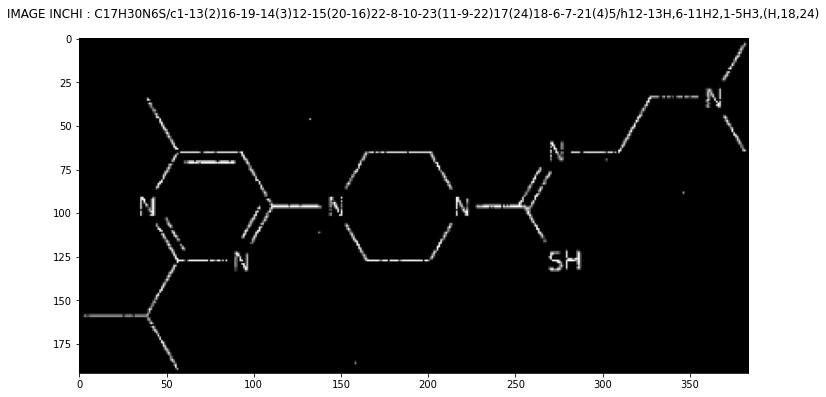

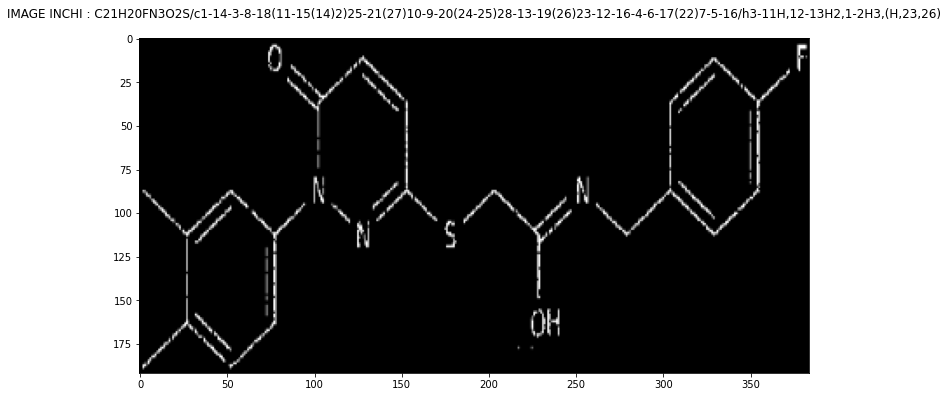

In [ ]:
####### ####### ####### ####### ####### ####### ####### #######

# Template Configuration
DS_TEMPLATE_CONFIG=dict(
    filenames=[],
    batch_size=1,
    is_test=False, 
    shuffle_buffer_size=1, 
    repeat_dataset=True, 
    preserve_file_order=False, 
    drop_remainder=True,
    tokenized_inchi=True,
    external_inchi_dataset=None,
    test_padding=0
)

####### ####### ####### ####### ####### ####### ####### #######

# Individual Respective Configurations
TRAIN_DS_CONFIG=DS_TEMPLATE_CONFIG.copy()
TRAIN_DS_CONFIG.update(dict(
    filenames=TRAIN_TFREC_PATHS,
    batch_size=OVERALL_BATCH_SIZE,
    shuffle_buffer_size=OVERALL_BATCH_SIZE*6,
))

VAL_DS_CONFIG=DS_TEMPLATE_CONFIG.copy()
VAL_DS_CONFIG.update(dict(
    filenames=VAL_TFREC_PATHS,
    batch_size=OVERALL_BATCH_SIZE,
))

####### ####### ####### ####### ####### ####### ####### #######

train_ds=get_dataset(**TRAIN_DS_CONFIG)
val_ds=get_dataset(**VAL_DS_CONFIG)
#test_ds=get_dataset(**TEST_DS_CONFIG)

for SPLIT, CONFIG in zip(["TRAINING", "VALIDATION"
                          #, "TESTING"
                         ], [TRAIN_DS_CONFIG, VAL_DS_CONFIG
                           #  , TEST_DS_CONFIG
                            ]): # , TEST_DS_CONFIG]
    print(f"\n... {SPLIT} CONFIGURATION:")
    for k,v in CONFIG.items():
        if k=="filenames":
            print(f"\t--> {k:<23}: {[path.split('/', 4)[-1] for path in v[:2]]+['...']}")
        else:
            print(f"\t--> {k:<23}: {v}")

print(f"\n\n... TRAINING DATASET   : {train_ds} ...")
print(f"... VALIDATION DATASET : {val_ds} ...")
#print(f"... TESTING DATASET    : {test_ds}    ...\n")

print("\n\n ... SOME VALIDATION EXAMPLES ... \n\n")
for x,y in val_ds.take(1):
    for i in range(2):
        plt.figure(figsize=(12,12))
        plt.imshow(x[i].numpy().astype(np.int64))
        plt.title(f"IMAGE INCHI : {''.join([int_2_tok[z] for z in y[i].numpy() if z not in [0,1,2]])}\n")
        plt.show()

# Model

## Params

In [ ]:
# 先把 decoder的参数放在这
num_layer=4
d_model=768
dff= 512
num_heads=8
target_vocab_size=VOCAB_LEN
dropout_rate=0.1 

# vision encoder 参数
image_size = (IMG_SHAPE[0], IMG_SHAPE[1])  # We'll resize input images to this size
patch_size = 16  # Size of the patches to be extract from the input images
num_patches = (image_size[0] // patch_size) * (image_size[1] // patch_size) 
projection_dim = d_model
vit_num_heads = 12
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 12

In [ ]:
print("\n... ENCODER MODEL CREATION STARTING ...\n")

# SAMPLE IMAGES
SAMPLE_IMGS, SAMPLE_LBLS=next(iter(val_ds.unbatch().batch(BATCH_SIZE_DEBUG)))



... ENCODER MODEL CREATION STARTING ...



## Attention architecture


In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
    
    """Calculate the attention weights.
    q, k, v must have matching leading dimensions.
    k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
    The mask has different shapes depending on its type(padding or look ahead) 
    but it must be broadcastable for addition.

    Args:
        q: query shape == (..., seq_len_q, depth)
        k: key shape == (..., seq_len_k, depth)
        v: value shape == (..., seq_len_v, depth_v)
        mask: Float tensor with shape broadcastable 
            to (..., seq_len_q, seq_len_k). Defaults to None.

    Returns:
        output, attention_weights
    """
    
    # (..., seq_len_q, seq_len_k)
    matmul_qk=tf.matmul(q, k, transpose_b=True)  
    
    # scale matmul_qk
    dk=tf.cast(tf.shape(k)[-1], TARGET_DTYPE)
    
    # Calculate scaled attention logits
    scaled_attention_logits=matmul_qk / tf.math.sqrt(dk)
    
    # add the mask to the scaled tensor.
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 
    
    # softmax is normalized on the last axis (seq_len_k) 
    # so that the scores add up to 1.
    #   - shape --> (..., seq_len_q, seq_len_k)
    attention_weights=tf.nn.softmax(scaled_attention_logits, axis=-1) 
    
     #   - shape --> (..., seq_len_q, depth_v)
    output=tf.matmul(attention_weights, v)  

    return output, attention_weights

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                # INNER LAYER
                #   – (batch_size, seq_len, dff)
                tf.keras.layers.Dense(dff, activation='relu'),
                 # INNER LAYER
                #   – (batch_size, seq_len, dff)
                tf.keras.layers.Dense(d_model)])

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads=num_heads
        self.d_model=d_model
        assert d_model % self.num_heads == 0
        self.depth=d_model // self.num_heads
        self.wq=tf.keras.layers.Dense(d_model)
        self.wk=tf.keras.layers.Dense(d_model)
        self.wv=tf.keras.layers.Dense(d_model)
        self.dense=tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        """ Split the last dimension into (num_heads, depth).
            Then we transpose the result such that the shape is 
                - (batch_size, num_heads, seq_len, depth)
        """
        x=tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size=tf.shape(q)[0]
        q=self.wq(q)  # (batch_size, seq_len, d_model)
        k=self.wk(k)  # (batch_size, seq_len, d_model)
        v=self.wv(v)  # (batch_size, seq_len, d_model)

        q=self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k=self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v=self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)
    
        # scaled_attention.shape – (batch_size, num_heads, seq_len_q, depth)
        # attention_weights.shape – (batch_size, num_heads, seq_len_q, seq_len_k)
        scaled_attention, attention_weights=scaled_dot_product_attention(q, k, v, mask)
        
        # (batch_size, seq_len_q, num_heads, depth)
        scaled_attention=tf.transpose(scaled_attention, perm=[0, 2, 1, 3]) 
    
        # (batch_size, seq_len_q, d_model)
        concat_attention=tf.reshape(scaled_attention,
                                 (batch_size, -1, self.d_model))  

        # (batch_size, seq_len_q, d_model)
        output=self.dense(concat_attention)  
        
        return output, attention_weights

## Position embedding

In [ ]:
def get_angles(pos, i, d_model):
    """
        angle_rates=1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
        return pos * angle_rates
    """
    # 浮点类型不匹配
    angle_rates = tf.constant(1, TARGET_DTYPE) / tf.math.pow(tf.constant(10000, TARGET_DTYPE), (tf.constant(2, dtype=TARGET_DTYPE) * tf.cast((i//2), TARGET_DTYPE))/d_model)
    return pos * angle_rates

# https://kazemnejad.com/blog/transformer_architecture_positional_encoding/
# https://stackoverflow.com/questions/46452020/sinusoidal-embedding-attention-is-all-you-need

# 这个需要改成tnt 或者vit
"""
def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0
    row_pos=np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos=np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row=get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col=get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    angle_rads_row[:, 0::2]=np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2]=np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2]=np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2]=np.cos(angle_rads_col[:, 1::2])
    pos_encoding=np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    #return tf.cast(pos_encoding, dtype=tf.float32)
    return tf.cast(pos_encoding, dtype=TARGET_DTYPE)
"""

'\ndef positional_encoding_2d(row,col,d_model):\n    assert d_model % 2 == 0\n    row_pos=np.repeat(np.arange(row),col)[:,np.newaxis]\n    col_pos=np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)\n\n    angle_rads_row=get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)\n    angle_rads_col=get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)\n\n    angle_rads_row[:, 0::2]=np.sin(angle_rads_row[:, 0::2])\n    angle_rads_row[:, 1::2]=np.cos(angle_rads_row[:, 1::2])\n    angle_rads_col[:, 0::2]=np.sin(angle_rads_col[:, 0::2])\n    angle_rads_col[:, 1::2]=np.cos(angle_rads_col[:, 1::2])\n    pos_encoding=np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]\n    #return tf.cast(pos_encoding, dtype=tf.float32)\n    return tf.cast(pos_encoding, dtype=TARGET_DTYPE)\n'

In [ ]:
def do_interleave(arr_a, arr_b):
    a_arr_tf_column = tf.range(arr_a.shape[1])*2 # [0 2 4 ...]
    b_arr_tf_column = tf.range(arr_b.shape[1])*2+1 # [1 3 5 ...]
    column_indices = tf.argsort(tf.concat([a_arr_tf_column,b_arr_tf_column],axis=-1))
    column, row = tf.meshgrid(column_indices,tf.range(arr_a.shape[0]))
    combine_indices = tf.stack([row,column],axis=-1)
    combine_value = tf.concat([arr_a,arr_b],axis=1)
    return tf.gather_nd(combine_value,combine_indices)

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(tf.cast(tf.range(position)[:, tf.newaxis], TARGET_DTYPE),
                            tf.cast(tf.range(d_model)[tf.newaxis, :], TARGET_DTYPE),
                            d_model)
    
    # apply sin to even indices in the array; 2i
    sin_angle_rads = tf.math.sin(angle_rads[:, ::2])
    cos_angle_rads = tf.math.cos(angle_rads[:, 1::2])
    angle_rads = do_interleave(sin_angle_rads, cos_angle_rads)
    pos_encoding = angle_rads[tf.newaxis, ...]
    return pos_encoding

## Encoder

In [ ]:
from tensorflow.keras import layers

In [ ]:
class PatchEncoder(layers.Layer):
    def __init__(self, patch_size, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        
        #self.projection = layers.Dense(units=projection_dim)

        self.conv =  layers.Conv2D(
            filters=self.projection_dim,
            kernel_size=self.patch_size,
            strides=self.patch_size,
            padding="valid",
            name="embedding",)
        
        self.reshape = tf.keras.layers.Reshape((self.num_patches, self.projection_dim))
        
        self.position_embedding = layers.Embedding(
            input_dim=self.num_patches, output_dim=self.projection_dim
        )
        self.add = layers.Add()

    def call(self, images):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        
        
        #proj = self.projection(patch)

        patches = self.conv(images)
        proj = self.reshape(patches)

        pos = self.position_embedding(positions)

        encoded = proj + pos
        return encoded

In [ ]:
class VIT_ENCODER(layers.Layer):
    def __init__(self, patch_size, num_patches, projection_dim, transformer_layers, transformer_units):
        super(VIT_ENCODER, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.transformer_layers = transformer_layers
        self.transformer_units = transformer_units
        self.dropout_rate = 0.1

        # divide patch
        #self.patches = Patches(self.patch_size)
        # Encode patches.
        self.PatchEncoder = PatchEncoder(self.patch_size, self.num_patches, self.projection_dim)

        self.layerNorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layerNorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.layerNorm3 = layers.LayerNormalization(epsilon=1e-6)

        self.mha = layers.MultiHeadAttention(
                num_heads=vit_num_heads, key_dim=projection_dim, dropout=0.1
            )
        
        self.add1 = layers.Add()
        self.add2 = layers.Add()
        

        #def mlp(x, hidden_units, dropout_rate):
       
        self.Denses = [layers.Dense(units, activation=tf.nn.gelu) for units in self.transformer_units]
        self.Dropouts = [layers.Dropout(self.dropout_rate) for _ in range(len(self.transformer_units))]

        #self.mlp = mlp

    def call(self, x, training):
        
        # Create patches.
        #patches = self.patches(x)
        # Encode patches.
        encoded_patches = self.PatchEncoder(x)

        # Create multiple layers of the Transformer block.
        for _ in range(self.transformer_layers):
            # Layer normalization 1.
            x1 = self.layerNorm1(encoded_patches)
            # Create a multi-head attention layer.
            attention_output = self.mha(x1, x1)
            # Skip connection 1.
            x2 = self.add1([attention_output, encoded_patches])
            # Layer normalization 2.
            x3 = self.layerNorm2(x2)
            # MLP.
            #x3 = self.mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
            for i in range(len(self.transformer_units)):
              x3 = self.Denses[i](x3)
              x3 = self.Dropouts[i](x3, training=training)

            # Skip connection 2.
            encoded_patches = self.add2([x3, x2])

        # Create a [batch_size, projection_dim] tensor.
        x = self.layerNorm3(encoded_patches)

        return x

## Decoder

In [ ]:
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.1):
        """ Decoder Layer Component Of Transformer Decoder Block 
        
        Args:
            d_model: the depth of the d-dimensional space used for positional encoding of image embedding
            num_heads: The number of heads to use in the multi-head-attention block
            dff (int): Number of units to use in the feed-forward neural network
            dropout_rate (float): Percentage of nodes to drop in a given layer
        
        Returns:
            none; This is an intiailization
        """
        super(DecoderLayer, self).__init__()
        self.mha1=MultiHeadAttention(d_model, num_heads)
        self.mha2=MultiHeadAttention(d_model, num_heads)
        
        # keras 多头注意力实现
        # # Multi Head Attention Layers
        # self.mha1 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model,)
        # self.mha2 = tf.keras.layers.MultiHeadAttention(num_heads, key_dim=d_model,)
             
        self.ffn=point_wise_feed_forward_network(d_model, dff)

        self.layernorm1=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2=tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3=tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1=tf.keras.layers.Dropout(rate)
        self.dropout2=tf.keras.layers.Dropout(rate)
        self.dropout3=tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        """ Call function for our encoder layer
        
        Args:
            self (class attributes): For the given layer, this exposes the attributes
            x (tf.float32 array): token embeddinng (batch_size, output_seq_len, embedding_dim)
            enc_output (tf.float32 array): token embeddinng (batch_size, output_seq_len, embedding_dim)
            training (bool): Whether or not to apply certain operations (i.e. disable/enable dropout)
            mask (): tbd
            
        Returns:
            The encoded input sequence
               - shape --> (batch_size, input_seq_len, d_model)
        """
        attn1, attn_weights_block1=self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1=self.dropout1(attn1, training=training)
        
        # Residual connection followed by layer normalization
        #   – (batch_size, target_seq_len, d_model)
        out1=self.layernorm1(attn1 + x)
        
        # Merging connection between encoder and decoder (MHA)
        #   – (batch_size, target_seq_len, d_model)
        attn2, attn_weights_block2=self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2=self.dropout2(attn2, training=training)
        
        # Residual connection followed by layer normalization
        #   – (batch_size, target_seq_len, d_model)
        out2=self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)
        
        # (batch_size, target_seq_len, d_model)
        ffn_output=self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output=self.dropout3(ffn_output, training=training)
        
        # Residual connection followed by layer normalization
        #   – (batch_size, target_seq_len, d_model)
        out3=self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

        return out3, attn_weights_block1, attn_weights_block2

print("\n... ATTENTION MECHANISM LAYER CREATION FINISHED ...\n")

print("\n... DECODER MODEL CREATION STARTING ...\n")



class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.1):
        super(Decoder, self).__init__()
        self.d_model=d_model
        self.num_layers=num_layers

        self.embedding=tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding=positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers=[DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout=tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len=tf.shape(x)[1]
        attention_weights={}

        x=self.embedding(x)  # (batch_size, target_seq_len, d_model)
        #x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x *= tf.math.sqrt(tf.cast(self.d_model, TARGET_DTYPE))
        #print(self.pos_encoding.shape, self.pos_encoding[:, :seq_len, :].shape)
        x += self.pos_encoding[:, :seq_len, :]
        x=self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2=self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)

            attention_weights['decoder_layer{}_block1'.format(i+1)]=block1
            attention_weights['decoder_layer{}_block2'.format(i+1)]=block2

        return x, attention_weights



print("\n... DECODER MODEL CREATION FINISHED ...\n")


... ATTENTION MECHANISM LAYER CREATION FINISHED ...


... DECODER MODEL CREATION STARTING ...


... DECODER MODEL CREATION FINISHED ...



# learning Rate Schedule 

In [ ]:
print("\n... LEARNING RATE SCHEDULE CREATION STARTING ...\n")


print("\n... LEARNING RATE SCHEDULE CREATION STARTING ...\n")

# Part of the Training Configuration
EPOCHS = 10
TOTAL_STEPS = TRAIN_STEPS*EPOCHS

CyclicalLearningRateScheduler = tfa.optimizers.CyclicalLearningRate(
 initial_learning_rate=3e-7, #3e-7,
 maximal_learning_rate=3e-5, #3e-5,
 step_size=TRAIN_STEPS*2,
 scale_fn=lambda x: 1 / (2.0 ** (x - 1)),
 scale_mode='cycle')

# # #https://towardsdatascience.com/super-convergence-with-cyclical-learning-rates-in-tensorflow-c1932b858252


... LEARNING RATE SCHEDULE CREATION STARTING ...


... LEARNING RATE SCHEDULE CREATION STARTING ...



In [ ]:
def plot_lr_schedule(lr_schedule, name=""):
    """ Plot the learning rate schedule over the course of training
    
    Args:
        lr_schedule (list of floats): The values to use for the LR over the
            course of training
        name (str, optional): A name for the LR schedule
    
    Returns:
        None; A plot of the how the learning rate changes over time will be displayed
    
    """
    schedule_info = f'start: {lr_schedule[0]:.6f}, max: {max(lr_schedule):.6f}, final: {lr_schedule[-1]:.6f}'
    plt.figure(figsize=(18,6))
    plt.plot(lr_schedule)
    plt.title(f"Step Learning Rate Schedule {name+', ' if name else name}{schedule_info}", size=16, fontweight="bold")
    plt.grid()
    plt.show()

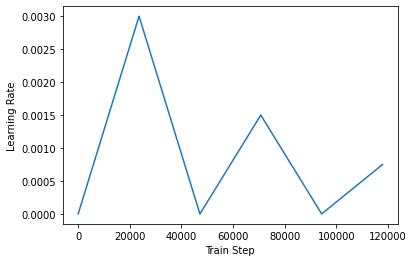

In [ ]:
plt.plot(CyclicalLearningRateScheduler(step=tf.range(TOTAL_STEPS, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")
plt.show()

In [ ]:
class Config():
    def __init__(self,):
        self.encoder_config={}
        self.decoder_config={}
        self.lr_config={}
    def initialize_lr_config(self):
        self.lr_config = dict(     
        )
        
training_config=Config()
training_config.initialize_lr_config()

print(f"TRAINING LEARNING RATE CONFIG:\n\t--> {training_config.lr_config}\n")

TRAINING LEARNING RATE CONFIG:
	--> {}



In [ ]:
print("\n... TRAINING PREPERATION STARTING ...\n")

def prepare_for_training(lr_config, encoder_wts=None, decoder_wts=None, verbose=0):
    

    # Everything must be declared within the scope when leveraging the TPU strategy
    #     - This will still function properly if scope is set to another type of accelerator
    with strategy.scope():
        
        print("\t--> CREATING LOSS FUNCTION ...")
        # Declare the loss object
        #     - Sparse categorical cross entropy loss is used as root loss
        loss_object=tf.keras.losses.SparseCategoricalCrossentropy(
            from_logits=True, reduction=tf.keras.losses.Reduction.NONE
        )
        
        def loss_fn(real, pred):
            # Convert to uint8
            mask = tf.math.not_equal(real, 0)
            loss_ = loss_object(real, pred)
            loss_ *= tf.cast(mask, dtype=loss_.dtype)

            # https://www.tensorflow.org/tutorials/distribute/custom_training#define_the_loss_function
            loss_ = tf.nn.compute_average_loss(loss_, global_batch_size=REPLICA_BATCH_SIZE)
            return loss_
        
        
        # Declare the metrics
        #    - Loss (train only) and sparse categorical accuracy will be used
        print("\t--> CREATING METRICS ...")
        metrics={
            'batch_loss':tf.keras.metrics.Mean(),
            'train_loss': tf.keras.metrics.Mean(),
            'train_acc': tf.keras.metrics.SparseCategoricalAccuracy(),
            'val_loss': tf.keras.metrics.Mean(),
            'val_acc': tf.keras.metrics.SparseCategoricalAccuracy(),
            'val_lsd': tf.keras.metrics.Mean(), 
        }
        
        print("\t--> CREATING OPTIMIZER ...")
        
        lr_scheduler = CyclicalLearningRateScheduler
        
        # Instiate an optimizer
        #optimizer=tf.keras.optimizers.Adam(lr_scheduler)
        #optimizer=tf.keras.optimizers.Adam()
        
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5)


        
        print("\t--> CREATING LEARNING RATE SCHEDULER ...")
        # Declare the learning rate schedule (try this as actual lr schedule and list...)
        


    # Show the model architectures and plot the learning rate
    if verbose:

        print("\n\n... LR SCHEDULE PLOT...\n")
        plot_lr_schedule(lr_schedule)
  
    return loss_fn, metrics, optimizer, lr_scheduler
    
    
print("\n... GENERATING THE FOLLOWING:")
# Instantiate our required training components in the correct scope
loss_fn, metrics, optimizer, lr_scheduler=\
    prepare_for_training(lr_config=training_config.lr_config,
                         encoder_wts=(ENCODER_CKPT_PATH if ENCODER_CKPT_PATH!="" else None),
                         decoder_wts=(DECODER_CKPT_PATH if DECODER_CKPT_PATH!="" else None),
                         verbose=0,)

print("\n... TRAINING PREPERATION FINISHED ...\n")


... TRAINING PREPERATION STARTING ...


... GENERATING THE FOLLOWING:
	--> CREATING LOSS FUNCTION ...
	--> CREATING METRICS ...
	--> CREATING OPTIMIZER ...
	--> CREATING LEARNING RATE SCHEDULER ...

... TRAINING PREPERATION FINISHED ...



## Transformer

In [ ]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, pe_target, rate=0.1):
        super(Transformer, self).__init__()
        print("num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, pe_target", num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, pe_target, rate)
        self.encoder= VIT_ENCODER(patch_size, num_patches, projection_dim, transformer_layers, transformer_units)
        self.decoder=Decoder(num_layers, d_model, num_heads, dff,
                          target_vocab_size, pe_target, rate)
        self.final_layer=tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None):
        enc_output=self.encoder(inp, training)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights=self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output=self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

In [ ]:
transformer = Transformer(num_layer, 
                          d_model,
                          num_heads, 
                          dff, 
                          target_vocab_size, 
                          num_patches,
                          MAX_LEN,
                          dropout_rate)

num_layers, d_model, num_heads, dff, target_vocab_size, pe_input, pe_target 4 768 8 512 197 288 138 0.1


# Load Weight

In [ ]:
!ls ./drive/MyDrive

'Colab Notebooks'   leatherData.drawio	 transformer_epoch_4.h5
 kaggle.json	    robot.drawio


In [ ]:

with strategy.scope():
  initialization_batch = tf.ones(((REPLICA_BATCH_SIZE,)+IMG_SHAPE), dtype=TARGET_DTYPE)
  transformer(initialization_batch, tf.random.uniform((REPLICA_BATCH_SIZE, 1)), training=False)
  transformer.summary()
  TRANSFORMER_CKPT_PATH = '/content/drive/MyDrive/transformer_epoch_4.h5'
  transformer.load_weights(TRANSFORMER_CKPT_PATH)


Model: "transformer"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vit_encoder (VIT_ENCODER)    multiple                  31517952  
_________________________________________________________________
decoder (Decoder)            multiple                  22219520  
_________________________________________________________________
dense_42 (Dense)             multiple                  151493    
Total params: 53,888,965
Trainable params: 53,888,965
Non-trainable params: 0
_________________________________________________________________


# LookForward mask

In [ ]:
def create_padding_mask(seq):
    # add extra dimensions to add the padding to the attention logits.
    #    - (batch_size, 1, 1, seq_len)
    seq=tf.cast(tf.math.equal(seq, 0), TARGET_DTYPE)
    return seq[:, tf.newaxis, tf.newaxis, :] 

def create_look_ahead_mask(size):
    mask=1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    #return mask  # (seq_len, seq_len)
    return tf.cast(mask, TARGET_DTYPE)
def create_masks_decoder(tar):

    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)

    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return combined_mask

# Train

In [ ]:
def train_step(_image_batch, _inchi_batch):

    tar_inp = _inchi_batch[:, :-1]
    tar_real = _inchi_batch[:, 1:]
    
    # TODO 此处可能不对
    #enc_padding_mask = create_padding_mask(_inchi_batch)
    # 其实是lookahead mask
    dec_mask = create_masks_decoder(tar_inp)
    
    #dec_padding_mask = create_padding_mask(_inchi_batch)
    
    
    with tf.GradientTape() as tape:
            predictions, _ = transformer(_image_batch, tar_inp, True, look_ahead_mask=dec_mask)
            batch_loss = loss_fn(tar_real, predictions)
            # TODO 此处可能不对
            # Update Accuracy Metric
            metrics["train_acc"].update_state(tar_real, predictions, 
                                              sample_weight=tf.where(tf.not_equal(tar_real, PAD_TOKEN), 1.0, 0.0))
        
    gradients = tape.gradient(batch_loss, transformer.trainable_variables)   
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    #train_loss(loss)
    #train_accuracy(tar_real, predictions)
    metrics["batch_loss"].update_state(batch_loss)
    metrics["train_loss"].update_state(batch_loss)
    
@tf.function
def dist_train_step(_image_batch, _inchi_batch):
    strategy.run(train_step, args=(_image_batch, _inchi_batch))

In [ ]:
def val_step(_image_batch, _inchi_batch):
    """ Forward pass (calculate gradients)
    
    Args:
        image_batch (): TBD
        inchi_batch (): TBD
    
    Returns:
        tbd
    """
    
    # Initialize batch_loss
    batch_loss = tf.constant(0.0, TARGET_DTYPE)       
    transformer_pred_batch = tf.ones((REPLICA_BATCH_SIZE, 1), dtype=tf.uint8)
    #transformer_pred_batch = tf.ones((OVERALL_BATCH_SIZE, 1), dtype=tf.uint8)
    
    # Get image embedding (once)
    #_image_embedding = encoder(_image_batch, training=False)
    
    # Teacher forcing - feeding the target as the next input
    for c_idx in range(1, MAX_LEN):
        gt_batch_id = _inchi_batch[:, c_idx]
        combined_mask = create_masks_decoder(transformer_pred_batch)
        
        # predictions.shape == (batch_size, seq_len, vocab_size)
        prediction_batch, attention_weights = transformer(_image_batch, transformer_pred_batch, training=False, look_ahead_mask=combined_mask)
        predicted_batch_id = prediction_batch[:, -1:, :]

        # Update Loss Accumulator
        batch_loss += loss_fn(gt_batch_id, predicted_batch_id[:, -1])
    
        # Update Accuracy Metric
        metrics["val_acc"].update_state(gt_batch_id, predicted_batch_id[:, -1],
                                        sample_weight=tf.where(tf.not_equal(gt_batch_id, PAD_TOKEN), 1.0, 0.0))

        # no teacher forcing, predicted char is next transformer input
        transformer_pred_batch = tf.concat([transformer_pred_batch, tf.cast(tf.argmax(predicted_batch_id, axis=-1), tf.uint8)], axis=-1)
        
    # Update Loss Metric
    metrics["val_loss"].update_state(batch_loss)
    return transformer_pred_batch    

    
@tf.function
def dist_val_step(_val_dist_ds):
    _val_image_batch, _val_inchi_batch = next(_val_dist_ds)
    predictions_seq_batch_per_replica = strategy.run(val_step, args=(_val_image_batch, _val_inchi_batch))
    predictions_seq_batch_accum = strategy.gather(predictions_seq_batch_per_replica, axis=0)
    _val_inchi_batch_accum = strategy.gather(_val_inchi_batch, axis=0)
    return predictions_seq_batch_accum, _val_inchi_batch_accum

In [ ]:
class StatLogger():
    def __init__(self, verbose_frequency=100, print_style="tight"):
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        self.val_lsd = []
        self.step = []
        self.epoch = []
        self.lr = []
        
        self.current_step = 0
        self.epoch_start_time = 0
        self.batch_start_time = 0
        self.verbose_frequency = verbose_frequency
        self.print_style = print_style
        
    def print_last_val(self, current_time):
        if self.print_style=="tight":
            print(f"| VAL DATA |  STEP {VAL_STEPS:>4}/{VAL_STEPS} |  " \
                  f"ACC: {str(self.val_acc[-1]*100)[:5]:<5} – " \
                  f"LOSS: {str(self.val_loss[-1])[:5]:<5} – " \
                  f"LSD: {str(self.val_lsd[-1]):<3} |")
        else:
            print(f'\n\n{"-"*100}\n{"-"*100}\n' \
                  f'{"-"*25:<25}{"VALIDATION ACCURACY : "+str(self.val_acc[-1]*100): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"VALIDATION LOSS     : "+str(self.val_loss[-1]): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"VALIDATION LSD      : "+str(self.val_lsd[-1]): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n{"-"*100}\n\n')
    
    def print_current_train(self, step, train_acc, train_loss, batch_loss, current_time, current_lr):
        if self.print_style=="tight":
            print(f"| TRAIN DATA |  STEP {self.current_step:>4}/{TRAIN_STEPS} | " \
                  f"ACC: {str(train_acc*100)[:5]:<5} – " \
                  f"LOSS: {str(train_loss)[:5]:<5} – " \
                  f"LR: {current_lr:.2e} " \
                  f"|   | TIME |  EPOCH: {str(round((current_time-self.epoch_start_time)/3600,1))+'h':<5} – " \
                  f"SUBSET: {str(round((current_time-self.batch_start_time)*self.verbose_frequency,1))+'s':<6} – " \
                  f"BATCH: {str(round(current_time-self.batch_start_time,1))+'s':<5} |")
        else:
            print(f'\n\n{"-"*100}\n{"-"*100}\n' \
                  f'{"-"*25:<25}{"CURRENT STEP : "+str(step)+" OF "+str(TRAIN_STEPS): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"CURRENT TRAIN ACCURACY : "+str(train_acc*100): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"CURRENT TRAIN LOSS     : "+str(train_loss): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"LAST BATCH LOSS        : "+str(batch_loss): ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n{"-"*100}\n' \
                  f'{"-"*25:<25}{"EPOCH ELAPSED TIME  : "+str(round(current_time-self.epoch_start_time,1))+" SECONDS": ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"LAST SET OF BATCHES TOOK  : ~"+str(round((current_time-self.batch_start_time)*self.verbose_frequency,1))+" SECONDS": ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n' \
                  f'{"-"*25:<25}{"LAST SINGLE BATCH TOOK  : "+str(round(current_time-self.batch_start_time,1))+" SECONDS": ^50}{"-"*25:>25}\n' \
                  f'{"-"*100}\n{"-"*100}\n\n')

In [ ]:
# Instantiate our tool for logging
stat_logger = StatLogger()
    
for epoch in range(1,EPOCHS+1):
    print(f'\n\n{"="*100}\n{"="*25:<25}{"EPOCH #"+str(epoch): ^50}{"="*25:>25}\n{"="*100}\n')
    
    stat_logger.current_step=0
    stat_logger.epoch_start_time = time.time() # to compute epoch duration
    
    # create distributed versions of dataset to run on TPU with 8 computation units
    train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
    val_dist_ds = iter(strategy.experimental_distribute_dataset(val_ds))

    for image_batch, inchi_batch in train_dist_ds:
                
        # Update current step
        stat_logger.batch_start_time = time.time()
        
        # Update the current step
        stat_logger.current_step += 1
        
        # Calculate training step
        dist_train_step(image_batch, inchi_batch)

        # end of epoch validation step
        if stat_logger.current_step == TRAIN_STEPS and epoch%2==0:
        #if stat_logger.current_step == TRAIN_STEPS:
            print("\n... VALIDATION DATASET STATISTICS ... \n")
            """
            for _ in range(VAL_STEPS):
                #preds, lbls = dist_val_step(val_dist_ds)
                #if epoch == EPOCHS+1:
                # metrics["val_lsd"].update_state(get_levenshtein_distance(preds, lbls))
            """

            # Record this epochs statistics
            stat_logger.train_loss.append(metrics["train_loss"].result().numpy())
            stat_logger.train_acc.append(metrics["train_acc"].result().numpy())
            stat_logger.val_loss.append(metrics["val_loss"].result().numpy())
            stat_logger.val_acc.append(metrics["val_acc"].result().numpy())
            stat_logger.val_lsd.append(metrics["val_lsd"].result().numpy())
            stat_logger.step.append(stat_logger.current_step)
            stat_logger.epoch.append(epoch)
            #stat_logger.lr.append(lr_scheduler.lr)
            stat_logger.lr.append(lr_scheduler(tf.cast(stat_logger.current_step+TRAIN_STEPS*(epoch-1), tf.float32)))
            
            # Reset the validation metrics as one epoch should not effect the next
            metrics["val_lsd"].reset_states()
            metrics["val_acc"].reset_states()
            metrics["val_loss"].reset_states()
            metrics["train_acc"].reset_states()
            metrics["train_loss"].reset_states()
            metrics["batch_loss"].reset_states()
            
            # Print validation scores
            stat_logger.print_last_val(current_time=time.time())
        
        # verbose logging step
        if stat_logger.current_step % stat_logger.verbose_frequency == 0:    
            stat_logger.print_current_train(
                stat_logger.current_step,
                metrics["train_acc"].result().numpy(), 
                metrics["train_loss"].result().numpy(), 
                metrics["batch_loss"].result().numpy(), 
                current_time=time.time(),
                #current_lr=lr_scheduler.lr
                current_lr=lr_scheduler(tf.cast(stat_logger.current_step+TRAIN_STEPS*(epoch-1), tf.float32))
            )
            metrics["train_acc"].reset_states()
            metrics["train_loss"].reset_states()
            metrics["batch_loss"].reset_states()

        # stop training when NaN loss is detected
        if stat_logger.current_step == TRAIN_STEPS:
            break
            
        # update learning rate
        #lr_scheduler.step(stat_logger.current_step+((epoch-1)*TRAIN_STEPS))
        
    # Save every other epoch (starting with first epoch)
    # Save after last epoch too...
    # if epoch%2==1 or epoch==EPOCHS:
    # save weights
    print("\n...SAVING MODELS TO DISK ... \n")
    #encoder.save_weights(f'./encoder_epoch_{epoch}.h5')
    #decoder.save_weights(f'./decoder_epoch_{epoch}.h5’）
    transformer.save_weights(f'./transformer_epoch_{epoch}.h5')



=========================                     EPOCH #1                     =========================

| TRAIN DATA |  STEP  100/11792 | ACC: 87.32 – LOSS: 32.00 – LR: 1.30e-05 |   | TIME |  EPOCH: 0.1h  – SUBSET: 118.0s – BATCH: 1.2s  |
| TRAIN DATA |  STEP  200/11792 | ACC: 87.49 – LOSS: 31.56 – LR: 2.57e-05 |   | TIME |  EPOCH: 0.1h  – SUBSET: 117.7s – BATCH: 1.2s  |
| TRAIN DATA |  STEP  300/11792 | ACC: 87.55 – LOSS: 31.45 – LR: 3.85e-05 |   | TIME |  EPOCH: 0.1h  – SUBSET: 117.6s – BATCH: 1.2s  |
| TRAIN DATA |  STEP  400/11792 | ACC: 87.58 – LOSS: 31.37 – LR: 5.12e-05 |   | TIME |  EPOCH: 0.2h  – SUBSET: 117.8s – BATCH: 1.2s  |
| TRAIN DATA |  STEP  500/11792 | ACC: 87.64 – LOSS: 31.26 – LR: 6.39e-05 |   | TIME |  EPOCH: 0.2h  – SUBSET: 117.7s – BATCH: 1.2s  |
| TRAIN DATA |  STEP  600/11792 | ACC: 87.75 – LOSS: 30.99 – LR: 7.66e-05 |   | TIME |  EPOCH: 0.2h  – SUBSET: 117.6s – BATCH: 1.2s  |
| TRAIN DATA |  STEP  700/11792 | ACC: 87.84 – LOSS: 30.56 – LR: 8.93e-05 |   | TIME |

KeyboardInterrupt: ignored

# Save CHKPT to GCS